# 1. Setup

In [333]:
import os
import glob
import time
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


# 2. Load Data

In [334]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

* 데이터의 shape가 (32,32,3) RGB필터를 가진 색상 이미지이다!

# 3. Data Preprocessing

In [335]:
# 데이터를 평균이 0, [-1,1] 구간에 들어오도록 정규화 작업 거침
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

# 데이터의 타입을 float32로 변경해줌
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
print(train_x.shape)

max pixel: 1.0
min pixel: -1.0
(50000, 32, 32, 3)


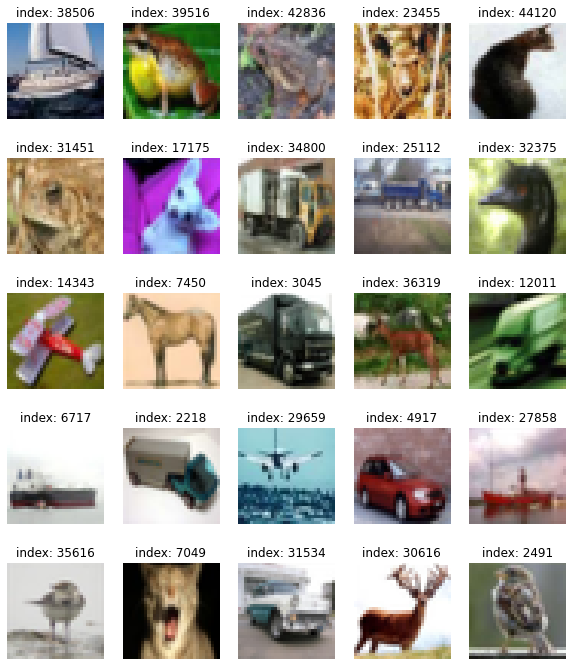

In [336]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2)
    plt.title(f'index: {random_index}')

    plt.axis('off')
plt.show()

In [337]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

* buffer size = 50000?
    - 50000개의 통에 50000장의 이미지를 넣고 Shffule한다는 의미
    - 40000으로 설정하면 나머지 1만장은 섞이지 않음

# 4. Generator 설계

In [338]:
def make_generator_model():

    # 모델시작
    model = tf.keras.Sequential()

    #레이어 차곡차곡 쌓자! 
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256))) # conv layer에서 연산하려면 reshape해줘야함

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model


![image](https://user-images.githubusercontent.com/68802402/131218436-c3923cf2-47a8-4183-bd31-b673c7f79000.png)

Transpose Convolution은 위 그림과 같이 작동하여 이미지의 size를 증가시키는 결과를 가져온다


In [339]:
generator = make_generator_model()

generator.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_67 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 16384)             0         
_________________________________________________________________
reshape_19 (Reshape)         (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_53 (Conv2DT (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_68 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_104 (LeakyReLU)  (None, 8, 8, 128)       

## Generator test

In [340]:
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

# 5. Discriminator 설계

In [341]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

* Generator 모델과의 차이점
       G : Conv2DTranspose 층을 사용해 이미지 크기 키움
       D : Conv2D 층을 사용해 이미지 크기 줄임

In [342]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_106 (LeakyReLU)  (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_107 (LeakyReLU)  (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 8192)            

In [343]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00091017]], dtype=float32)>

# 6. Loss function 정의

In [344]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [345]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

* GAN에서 accuracy
    - 1에 가깝다고 좋은가?<br/>X - 학습 초기에 generator은 제대로 못만들어서 Discriminator가 모두 판별 가능
    - accuracy가 시간이 지날수록 떨어지면서 0.5에 수렴하는 것이 바람직함
<br/><br/>
*  tf.math.greater_equal
    - 0.5 이상이면 True, 미만이면 False로 뱉음
* tf.cast   
    - tf.cast( (1), tf.float32) : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
* tf.reduce_mean
    - tf.reduce_mean( (2)) : (2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산


### 최적화 함수 (optimizer)

In [346]:
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
# "learning rate"는 0.0001

In [347]:
num_examples_to_generate = 16
noise_dim = 100

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [348]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

* @tf.function 데코레이터
<br/>위 데코레이터는  Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환시켜주는 데코레이터이다.

In [349]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1.0 ) / 2.0
    fig = plt.figure(figsize=(4, 4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i], vmin=0,vmax=1)
        plt.axis('off')

    plt.savefig('{}/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()


In [350]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 8    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [351]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

* 모델 CheckPoint 만들기
    1. 네트워크 끊김, 예상치 못한 문제로 학습한 모델을 잃으면 낭패!
    2. heckpoint에 optimizer와 생성자, 구분자를 모두 넣어 저장한다.
    

In [352]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [353]:
save_every = 5
EPOCHS = 500

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 7. Train

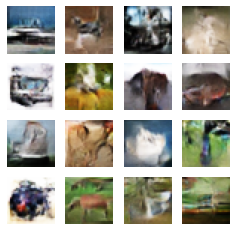

Time for training : 14971 sec


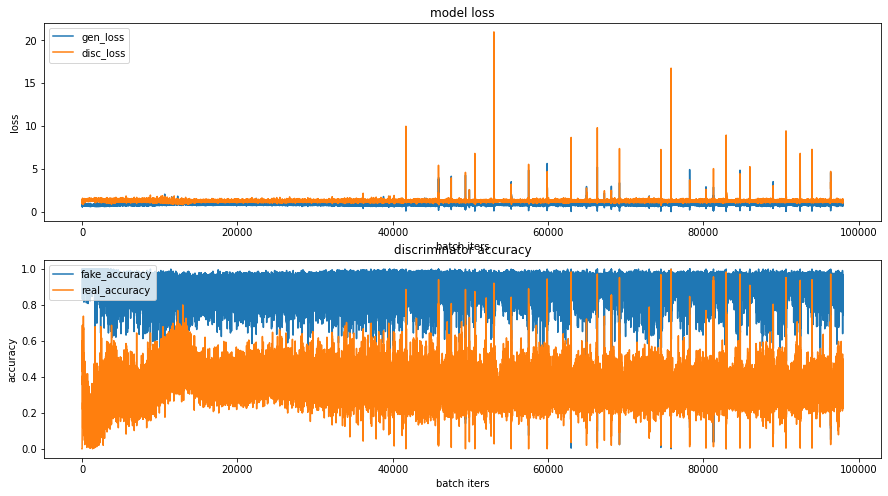

CPU times: user 4h 9min 28s, sys: 2min 44s, total: 4h 12min 13s
Wall time: 4h 9min 35s


In [354]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss,; accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/cifar10/training_history 경로에 생성되고 있으니
# 진행 과정을 수시로 확인해 보시길 권합니다.

# 8. Save Data

In [355]:
anim_file = os.getenv('HOME')+'/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/fashion_mnist_dcgan_epoch500.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_3/fashion_mnist_dcgan_epoch500.gif

ls: cannot access '/aiffel/aiffel/dcgan_newimage/cifar10_3/fashion_mnist_dcgan_epoch500.gif': No such file or directory


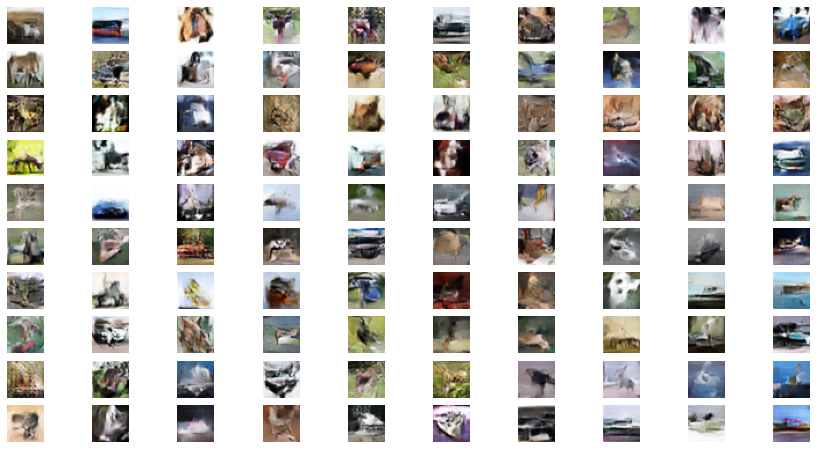

In [374]:
for i in range(100):
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    plt.subplot(10, 10, i+1)
    random_index = np.random.randint(1, 50000)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')


![image](https://user-images.githubusercontent.com/68802402/131770754-e76262e9-95ea-45a6-ab5d-90ca8654a305.png)

![fashion_mnist_dcgan_epoch500](https://user-images.githubusercontent.com/68802402/131771235-a2d8c529-0178-47d0-8721-eb1b07b2c1ac.gif)
<center>에폭 500</center>  




* 말과 비슷한 이미지, 차와 비슷한 이미지 등이 플롯됨
![image](https://user-images.githubusercontent.com/68802402/131770848-3eb47123-59ab-4345-a564-a7127cb609ab.png)

![image](https://user-images.githubusercontent.com/68802402/131770862-8c8088ef-848d-4d15-a856-c4142fec2f19.png)
![image](https://user-images.githubusercontent.com/68802402/131770903-5731a605-12a3-48b6-8a42-3694820ca97b.png)
![image](https://user-images.githubusercontent.com/68802402/131770994-3f3cd31e-43b6-445a-b9e5-7e4539e4eeb2.png)

* 하지만 뛰어난 성능이라고 말하기는 힘들 정도임


# 9. Load Checkpoint 
추가 학습이 필요한 경우 save한 checkpoint데이터를 이용하여 이어서 학습 가능

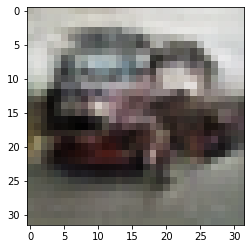

In [365]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/training_checkpoints'
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.figure(figsize=(4,4))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

* 개구리와 비슷한 형상의 이미지가 generate 됨

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/fashion_mnist_dcgan_epoch100.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/Project_files/GAN/dcgan_newimage/cifar10_3/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10_3/fashion_mnist_dcgan_epoch100.gif'

# 성능 향상 시도
### 1. latent space (=latent dim) 변경(100->300)

- 생각 흐름<br/><br/>
    - gray scale(1 filter) -> RGB (3 filter) 변경 : latent_dim도 3배로 늘려서 300으로 하는게 좋을거야
        - 결과 : 50 에폭 진행했지만 형편없는 그림 나옴<br/><br/>
![fashion_mnist_dcgan](https://user-images.githubusercontent.com/68802402/131241301-b8aa0737-88f4-4509-9be3-e24e8e5f95b0.gif)
    - epoch이 부족했나? epoch 50 -> 100 변경
    ![fashion_mnist_dcgan_epoch100](https://user-images.githubusercontent.com/68802402/131242706-e8a6d8a1-cfbe-4e72-bc73-2b6a53a7a6d4.gif)
    - 왜이럴까?
    

#### latent space의 정의 / 높아질수록 학습 성능 떨어짐

![image](https://user-images.githubusercontent.com/68802402/131432365-2200a1bd-bf29-4ced-b641-fcdcfcc3a691.png)
**Thus, as dimensionality is reduced, the ‘extraneous’ information which is distinct to each image (i.e. chair color) is ‘removed’ from our latent space representation, since only the most important features of each image are stored in the latent space representations.**<br/><br/>
필터가 3개로 늘어나서 n_dim을 늘려서 학습시킨 나의 불찰이었다. 차원을 늘려서 쓸데없는 feature까지 모델이 신경써서 학습 진행이 제대로 진행되지 않았던 것. <br/>
**latent space의 차원을 낮춰서 다시 진행하자**




### 2. 성공사례 코드 인용 (D,G 파라미터 인용)
[성공사례](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/)


#### 특징
>1. Discriminator 설계에서 각 층에서 Dropout하지 않고 Flatten 후에 한번만 Dropout함
2. D,G 모델의 파라미터가 다름
3. Latetn


![image](https://user-images.githubusercontent.com/68802402/131431469-3fa0d225-6a7f-42c3-96cd-fe972642947e.png)


![fashion_mnist_dcgan_epoch100](https://user-images.githubusercontent.com/68802402/131525742-99e5ae10-02e1-4764-b544-5cabfc1206e6.gif)
    <center>에폭 100 GIF</center>  

![fashion_mnist_dcgan_epoch200](https://user-images.githubusercontent.com/68802402/131525803-f6b00969-d02d-4ee9-923a-f337462a4860.gif)
<center>에폭 200 GIF</center>  

![fashion_mnist_dcgan_epoch260](https://user-images.githubusercontent.com/68802402/131525859-2d706b54-984e-4277-baff-1a1b3a6f095b.gif)
<center>에폭 260 GIF</center>  
<center>말의 형상이나 강아지의 형상이 잠깐 보이는 듯 하지만 만족스러운 결과는 아니다</center>  



* 에폭을 300 가까이 가져갔음에도 불구하고 Edge조차 제대로 생성하지 못하고 있음
* Discriminator의 Loss가 0으로 거의 수렴하고, D,G의 Accuracy가 모두 1에 수렴한다.<br/>
    - 이는 D가 가짜이미지를 가짜이미지로 잘맞춘다는 의미다
    - 즉, G가 가짜 이미지를 적절히 못만들고 있다는 의미가 된다. 다른 모델을 고안해봐야겠다.
* 성공사례의 Discriminator과 Generator 에서 커널의 사이즈에 대한 정보만 가져왔고, optimizer에 대한 정보를 가져온 것은 아니어서 그런지 300에폭가까이 진행해도 CIFAR10 이미지가 출력되진 않고 있다.



### 3. Adam Optimizer learning rate 늘리기
학습 속도를 늘리기 위해 Learning rate를 0.0001 --> 0.0002로 늘려보자

![fashion_mnist_dcgan_epoch100 (1)](https://user-images.githubusercontent.com/68802402/131598340-be7988a0-e205-4686-8734-8bb0db59ca2a.gif)    <center>에폭 100 GIF</center>  

![fashion_mnist_dcgan_epoch200 (1)](https://user-images.githubusercontent.com/68802402/131598361-6717e009-43d7-4755-aefd-2e8e2b42ae19.gif)
<center>에폭 200 GIF</center>  

![fashion_mnist_dcgan_epoch300](https://user-images.githubusercontent.com/68802402/131598372-9fbe351a-6937-4d8b-b6e2-339cdf1f0202.gif)
<center>에폭 300 GIF</center>  


* Convolution Layer의 parameter를 건드린 2번의 사례보다 더 결과가 좋지 않다.
* 기존의 Learning rate가 0.0001인데 2배로 늘린 것이 큰 영향을 준 듯 하다.
    - 이미지 픽셀 값의 범위를 [-1,1] 로 지정했기 때문에 learning rate변화에 더 민감하게 반응한 듯 하다.



# 성능 향상을 위한 방법 정리
1. **normalize the images between -1 and 1**
2. Use **Adam Optimization**
3. **Avoid** Sparse Gradients: **ReLU, MaxPool**
4. **Use DCGAN** when you can. It works!<br/>**if you cant use** DCGANs and no model is stable, **use a hybrid model : KL + GAN or VAE + GAN**
5. In GAN papers, the loss function to optimize G is min (log 1-D), but in practice folks practically **use max log D**
6. **Track failures early**
    - D loss goes to 0: failure mode
    - check norms of gradients: if they are over 100 things are screwing up
    - when things are working, D loss has low variance and goes down over time vs having huge variance and spiking
    - if loss of generator steadily decreases, then it's fooling D with garbage (says martin)
    
    
7. The model for the **discriminator is usually more complex than the generator** (more filters and more layers) and a good discriminator gives quality information

8. While training your **GAN use a batch size smaller than or equal to 64**. Using a bigger batch size might hurt the performance


[Tips On Training Your GANs Faster and Achieve Better Results](https://medium.com/intel-student-ambassadors/tips-on-training-your-gans-faster-and-achieve-better-results-9200354acaa5)

[Ways to improve GAN performance](https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b)

# 고찰
1. GAN의 성능을 올리는 방법을 다룬 블로그 글이나 논문은 수없이 많이 인터넷에 있다.
    하지만 그러한 글들의 Learnin rate, 모델을 따라한다고 해서 내 모델에서 잘 돌아가는 것은 아님
2. 에폭을 많이 가져갈 수록 "사람 눈"에 만족스러운 그림이 나오는 것 같긴 하지만 D,G의 accuracy나 loss는 사람과 많이 다른 듯 하다.
3. StyleGAN에도 관심이 생겨 공부해보고 싶다.